In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.tree import plot_tree

In [78]:
# Load dataset (Assuming CSV file)
df = pd.read_csv("structured_parking_data_2024.csv")


In [79]:
#cleaning the data
df.isnull().sum()


Timestamp                      0
Parking_Lot_ID                 0
Total_Parking_Slots            0
Hour                           0
Weather                        0
Event                          0
Holiday                        0
Available_Car_Spots            0
Available_Van_Spots            0
Available_Truck_Spots          0
Available_Motorcycle_Spots     0
Avg_Entry_15Min                0
Avg_Exit_15Min                 0
Avg_Waiting_Time               0
Rush_Time                      0
Car_Booking_Count              0
Van_Booking_Count              0
Truck_Booking_Count            0
Motorcycle_Booking_Count       0
Total_Booking_Count            0
Total_Available_Slots          0
Total_Used_Slots               0
Regular_Customer_Count         0
VIP_Customer_Count             0
Subscription_Customer_Count    0
OneTime_Customer_Count         0
Total_Customer_Type            0
dtype: int64

In [80]:
# Convert 'Recorded Date & Time' to datetime format and extract useful features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Timestamp'] = df['Timestamp'].astype('int64') // 10**9  # Convert to UNIX timestamp (seconds)

In [81]:
# Feature Selection
X = df[['Parking_Lot_ID','Timestamp', 'Weather', 'Hour', 'Avg_Entry_15Min', 'Avg_Exit_15Min', 'Avg_Waiting_Time']]
y = df['Rush_Time']  # Target Variable (1 if rush hour, else 0)


In [82]:
# Encode categorical data
X = pd.get_dummies(X, columns=['Weather'], drop_first=True)
X

,Parking_Lot_ID,Timestamp,Hour,Avg_Entry_15Min,Avg_Exit_15Min,Avg_Waiting_Time,Weather_Rainy,Weather_Snowy,Weather_Sunny
0,1,1704067200,0,5,16,6.50,False,False,False
1,2,1704067200,0,29,7,8.74,False,False,False
2,3,1704067200,0,13,25,3.08,False,False,False
3,4,1704067200,0,8,22,6.96,False,False,False
4,5,1704067200,0,16,6,4.56,False,False,False
...,...,...,...,...,...,...,...,...,...
351355,6,1735688700,23,12,5,9.81,False,True,False
351356,7,1735688700,23,20,24,2.96,False,True,False
351357,8,1735688700,23,16,11,4.63,False,True,False
351358,9,1735688700,23,6,23,1.58,False,True,False


In [83]:
#y valu count
print(y.value_counts())

Rush_Time
1    269572
0     81788
Name: count, dtype: int64


In [84]:
#balancing the dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)
y.value_counts()

Rush_Time
1    269572
0    269572
Name: count, dtype: int64

In [85]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
# Model Training
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

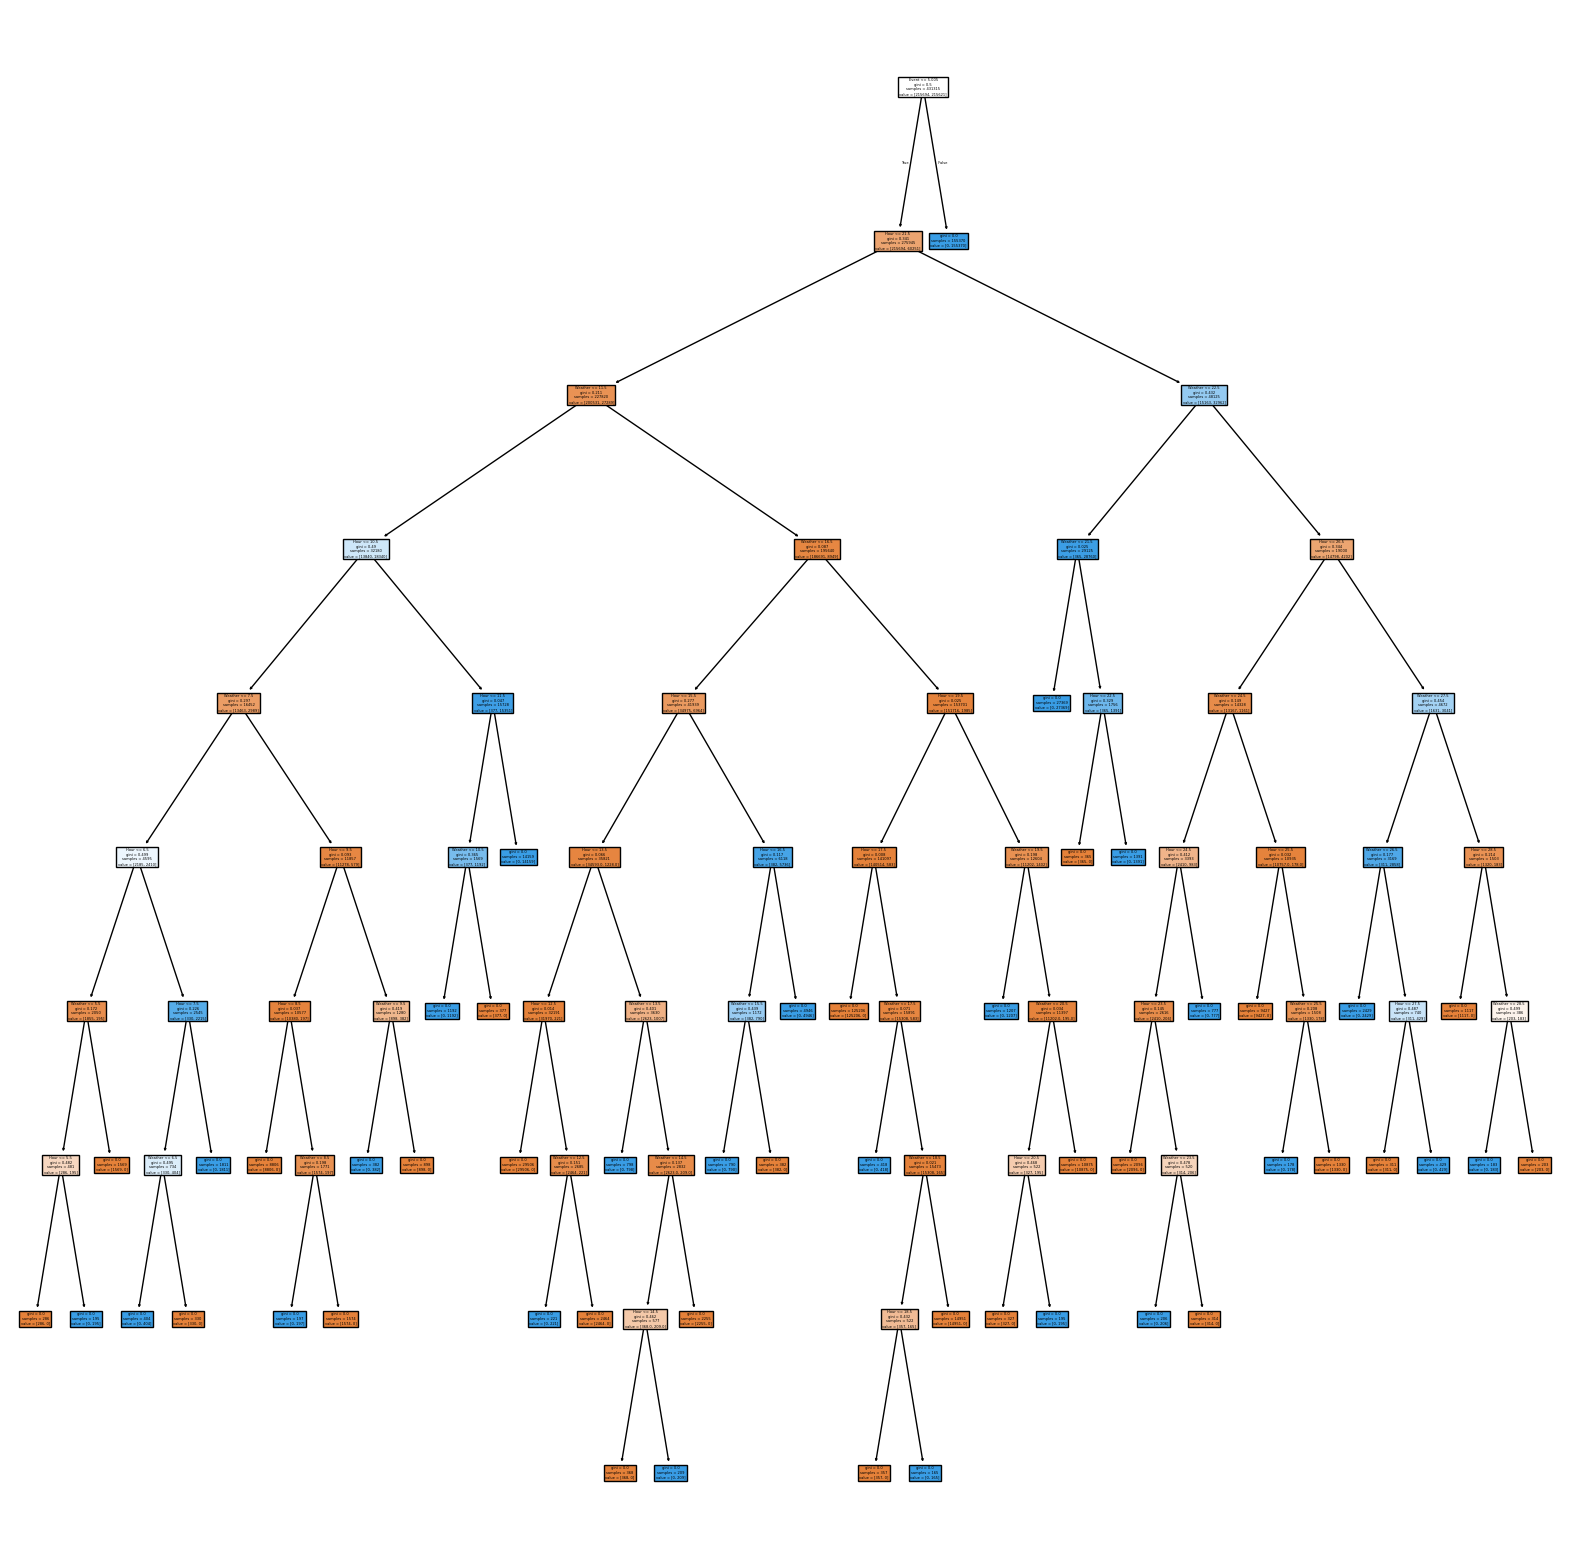

In [87]:
plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=(df.columns),filled=True)
plt.show()

In [88]:
cltp=DecisionTreeClassifier(criterion='entropy',max_depth=3)
cltp.fit(X_train,y_train)#fitting the model with training data set 

DecisionTreeClassifier(criterion='entropy', max_depth=3)

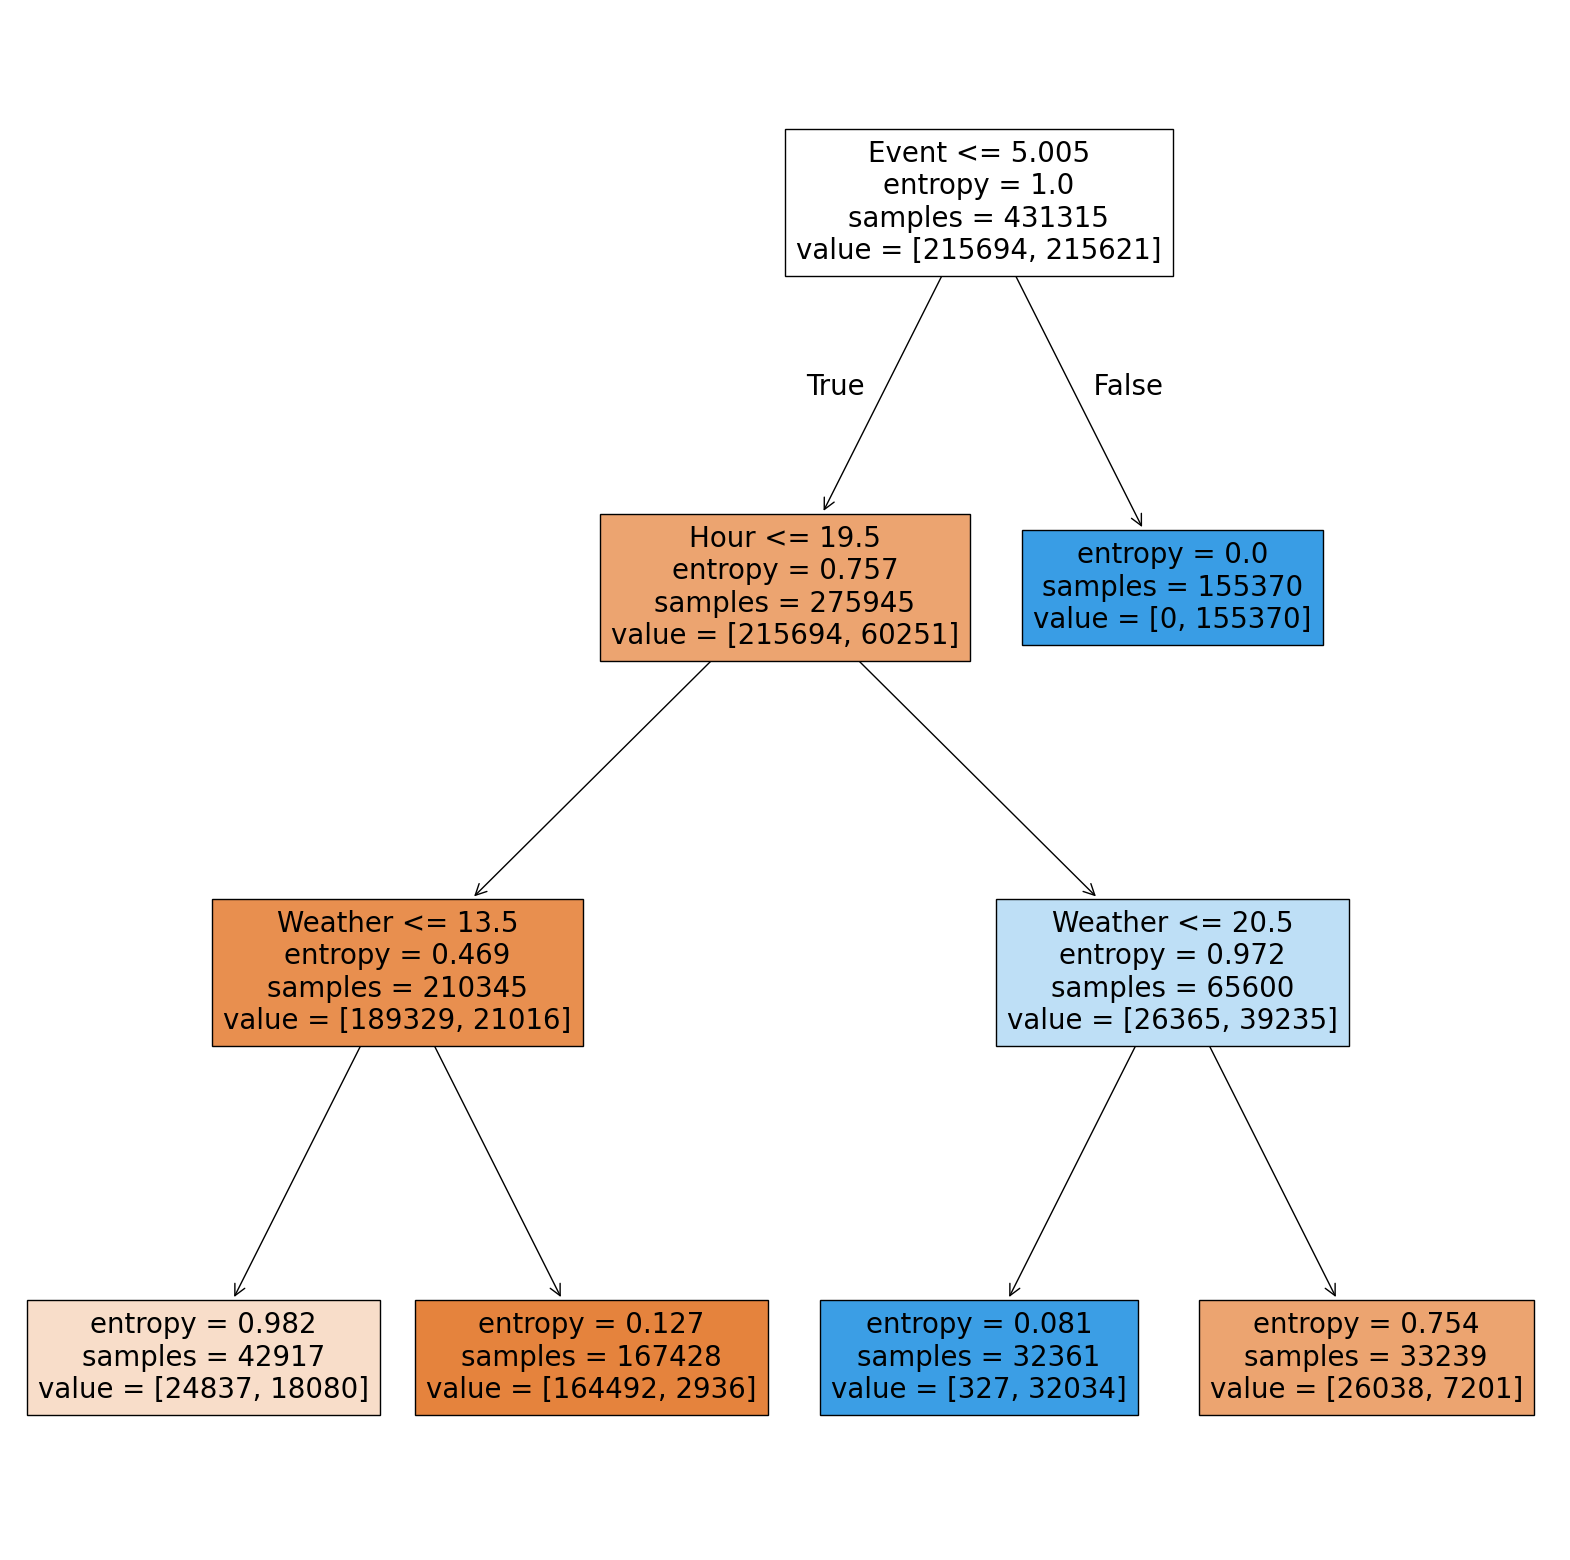

In [89]:
plt.figure(figsize=(20,20))
plot_tree(cltp, feature_names=(df.columns),filled=True)
plt.show()

In [90]:
# Predictions
y_pred = clf.predict(X_test)

In [91]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print Evaluation Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC Score: {auc:.2f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
ROC-AUC Score: 1.00
Confusion Matrix:
 [[53878     0]
 [    0 53951]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     53878
           1       1.00      1.00      1.00     53951

    accuracy                           1.00    107829
   macro avg       1.00      1.00      1.00    107829
weighted avg       1.00      1.00      1.00    107829



In [92]:
# Save the model
import joblib
joblib.dump(clf, 'parking_rush_hour_model.pkl')

['parking_rush_hour_model.pkl']

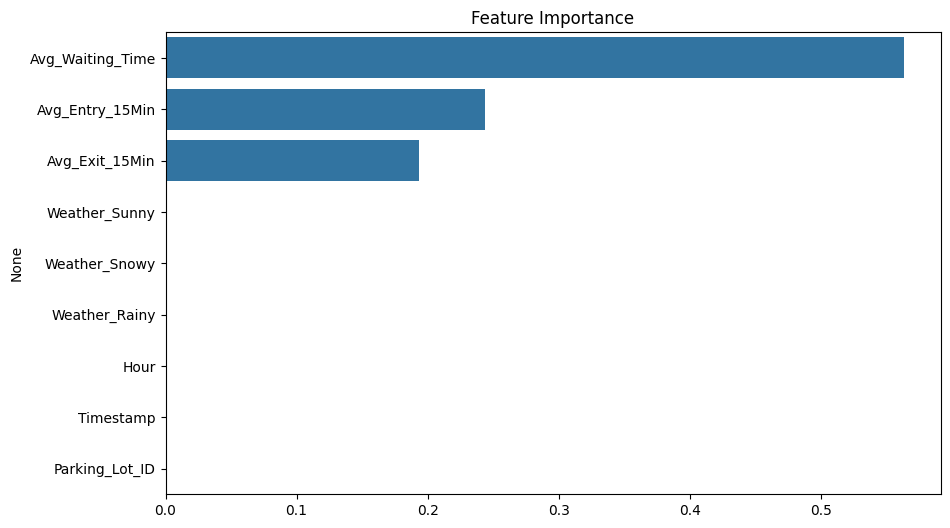

In [93]:
#show relative importance of features
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

feature_importance = clf.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[indices], y=feature_names[indices])
plt.title("Feature Importance")
plt.show()


In [94]:
import pandas as pd
import joblib
import numpy as np

def predict_rush_hour(timestamp, weather):
    
    # Load the trained model
    clf = joblib.load("parking_rush_hour_model.pkl")

    # Convert timestamp to UNIX format if it's a string
    if isinstance(timestamp, str):
        timestamp = pd.to_datetime(timestamp).timestamp()
    
    # Extract the hour from timestamp
    hour = pd.to_datetime(timestamp, unit='s').hour

    # Create a DataFrame for the new data
    new_data = pd.DataFrame({
        'Timestamp': [int(timestamp)],  # Ensure integer format
        'Weather': [weather],           # Example weather condition
        'Hour': [hour]                  # Extracted hour
    })

    # One-hot encode 'Weather' column (match training format)
    new_data = pd.get_dummies(new_data, columns=['Weather'], drop_first=True)

    # Load feature names (optional)
    try:
        model_features = joblib.load("model_features.pkl")  # Load saved feature names
    except FileNotFoundError:
        model_features = clf.feature_names_in_  # Extract directly from model

    # Ensure all expected features exist in new_data
    for col in model_features:
        if col not in new_data:
            new_data[col] = 0  # Add missing columns with default value

    # Reorder columns to match training order
    new_data = new_data[model_features]

    # Convert to NumPy array (optional, ensures compatibility)
    new_data = np.array(new_data)

    # Predict rush hour (1 = Rush Hour, 0 = Not Rush Hour)
    prediction = clf.predict(new_data)

    return prediction[0]

# Example Usage:
result = predict_rush_hour("2025-03-20 18:00:00", "Sunny")
print("Predicted Rush Hour Status:", result)


Predicted Rush Hour Status: 0


C:\Users\Tharindu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
